# Linear Regression

We have a bunch of dots and we want to "fit" the "best" straight line through them. The "best" line would be the one that results in the smallest difference between the dots' y's and their parallel to the y-axis projection onto the line. A "straight line" is  
    
$$y = m*x + b$$

IE, the representation of a line is a pair of two numbers - a slope(m) and an intercept(b). Our machine learning algorithm will have to find two weights:

$$w_1\text{ - the slope 'm'}$$
$$w_2\text{ - the y-intercept 'b'}$$

#### Let's make some data

In [53]:
import numpy as np

def generate_data_around_straight_line(slope, intercept, num_data_points, x_min, x_max):
    """ Generates x,y pairs around the (slope * x + intercept) line

    Parameters
    ----------
    slope : int
        slope of the line (the m from m*x +b)
    intercept : int
        y-intercept of the line (the b from m*x +b)
    num_data_points : int
        PER LABEL number of data points to generate:
        it will generate num_data_points with label 0 PLUS
        num_data_points with label 1
    x_min : int
        The min value of the X range
    x_max : int
        The max value of the X range
        
    Returns
    -------
    all_records
        2-D numpy array, rows of (x, y) pairs
    """

    # range X values between x_min and x_max
    x_values = np.round(np.random.uniform(low=x_min, high=x_max, size=num_data_points), decimals=2)

    y_low = slope * (x_min if slope > 0 else x_max) + intercept
    y_high = slope * (x_max if slope > 0 else x_min) + intercept

    y_values = slope * x_values + intercept
    
    noise = np.random.normal(0, 1, num_data_points)
    
    y_values = y_values + noise
    
    all_records = np.vstack((x_values, y_values)).T


    return all_records

In [54]:
this_slope=1
this_intercept=1
this_num_data_points=200
this_x_min=-5
this_x_max=5

data = generate_data_around_straight_line(this_slope, this_intercept, this_num_data_points, this_x_min, this_x_max)
print(data[:10, :])

[[-1.64000000e+00  3.00876885e-01]
 [ 1.43000000e+00  2.51690913e+00]
 [ 5.20000000e-01  1.98297527e+00]
 [-6.00000000e-02  8.39969924e-01]
 [-3.42000000e+00 -1.56356332e+00]
 [ 2.47000000e+00  2.41306759e+00]
 [-3.50000000e+00 -2.68628150e+00]
 [ 2.18000000e+00  3.87771916e+00]
 [ 3.29000000e+00  4.26394496e+00]
 [-2.98000000e+00  1.09213544e-04]]


That's nice, but can we plot it for mere mortals? 

Sure, here's plot function:

In [55]:
import matplotlib.pyplot as plt

def plot_records(records, slope, intercept, x_min, x_max):

    x_values = records[:, 0]
    y_values = records[:, 1]
    plt.scatter(x_values, y_values, c='blue', marker="x")
    
    #plot the line that produced the noisy points
    y_min = slope * x_min + intercept
    y_max = slope * x_max + intercept
    
    plt.axline((x_min, y_min), (x_max, y_max), c='deepskyblue')
    
    return plt

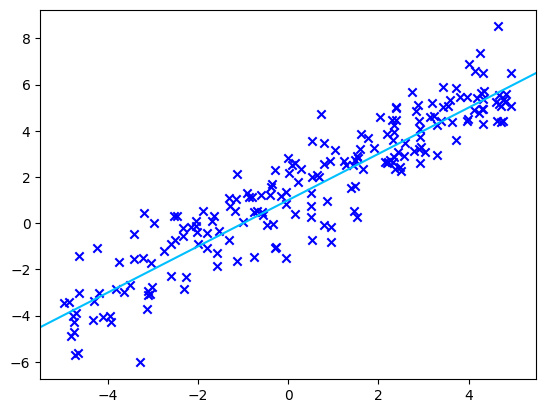

In [56]:
this_plot = plot_records(data, this_slope, this_intercept, this_x_min, this_x_max)
this_plot.show()

Okay, we have some data. Can we code up something that would give us a decent line that fits these points with a line fairly well? Hopefully something pretty close to the light blue line? Something that tells us that the slope(m, $w_1$) is around 1 and the intercept(b, $w_2$) is around 1.

We could guess the weights(slope and intercept) and then see how good(or most likely bad) our guess is. We keep guessing until our guesses aren't getting any better. The trick is to figure out how to have a better guess the next time around. This is where clever math helps. More on this in just a bit...

We measure how good our guess of a line is by finding the difference between the Y's for X's and their projection on the line we guessed. If we have a line guess -  a pair of slope($w_1$), intercept($w_2$), we just crunch in our X to find the $\hat{y}$ - the Y projection on that line: $\hat{y} = w_1*x + w_2$

Now that we have all $\hat{y}$'s, we can see by how much they are off by summing up absolute differences between the $\hat{y}$'s and the $y$'s. We could also find the average difference by dividing the sum by the number of records. This is one way of how good(or bad) our guess of weights is. This is one way of represening error, also known as loss.

Another way to measure loss is sum of squared differences: $(\hat{y} - y)^2$

The advantage of using the squared differences is that it can point us at the correct direction for guessing better weights. This is to do with the clever math mention. We will take a derivative of the loss function $(\hat{y} - y)^2$, this will give as the slope, ie the direction of ascent, ie the direction at which this loss function grows. We want to go in the direction of descent, ie the direction at which the loss function decreases. We'd adjust our weights in the direction opposite of the derivative of $(\hat{y} - y)^2$.

How are our weights(slope and intercept) related to the loss function:
$$(\hat{y} - y)^2 <=>$$
$$((w_1*x + w_2) - y)^2$$

Okay, we should call this derivative, a gradient, since it has two dimensions - $w_1$ and $w_2$. So a vector of two derivatives, one for $w_1$ and one for $w_2$ would be the gradient. We would be going in the direction of gradient descent.

Our derivitive in the $w_1$ direction, aka the partial derivative with respect to $w_1$ is
$$2*((w_1*x + w_2) - y)*x$$
The 2 is just a scalar, which won't affect the direction, so we can just drop it. To drop the 2, we could have also defined the loss function as $$\frac{1}{2}*(\hat{y} - y)^2$$
Which would give us a partial gradient of
$$((w_1*x + w_2) - y)*x$$
or
$$(\hat{y} - y)*x$$

Our derivitive in the $w_2$ direction, aka the partial derivative with respect to $w_2$ is
$$2*((w_1*x + w_2) - y)*1$$
or
$$((w_1*x + w_2) - y)*1$$ after dropping the 2
or
$$(\hat{y} - y)$$

#### Enough yapping, let's code stuff up.

In [57]:
def linear_regression(training_records, num_epochs, learning_rate=0.1):
    
    num_x_dims = training_records.shape[1] - 1
    weights = np.random.uniform(-1, 1, [num_x_dims + 1, 1])
    w1 = weights[0, 0]
    w2 = weights[1, 0]
    
    # to make the vectorized math easier
    # we add a column of one's right before the y's
    # the data would look like x, 1, y
    # so we can dot (w1, w2) with (x, 1) to find y_hat
    
    ones = np.ones(training_records.shape[0])
    training_records = np.insert(training_records, -1, ones, axis=1)
    
    previous_rmse = 900
    for epoch_num in range(num_epochs):
        x_s = training_records[:, :-1]
        y_s = training_records[:, -1, np.newaxis]
        # the new axis is just to come as (num_records, 1) shape
        # so it matches up the shape of y_hats
        
        y_hats = np.dot(x_s, weights)
        y_hats_minus_y = y_hats - y_s
        y_hats_minus_y_mult_x = y_hats_minus_y * x_s

        # since we added an extra column of 1s for w2
        # y_hats_minus_y_mult_x should be a 2-d array
        # where the first column is the partial derivative with respect to w1 and
        # where the second column is the partial derivative with respect to w2
        
        # now we find the average gradient for all records
        # this is a batch implementation
        # for stochastic, we would have looped over all the records
        # and adjusted to weights after each record
        avg_gradient = np.mean(y_hats_minus_y_mult_x, axis=0, keepdims=True)

        weights = weights - learning_rate * avg_gradient.T
        
        rmse = np.sqrt(np.mean(np.square(y_hats_minus_y)))
        rmse_improvement = previous_rmse - rmse
        previous_rmse = rmse
        
        if epoch_num % 10 == 0 and epoch_num != 0:
            print(f'epoch {epoch_num} rmse: {rmse}, improvement: {rmse_improvement}')
            print(f'weights: {weights.T}\n')
            
        
    return weights
        
    
learned_weights = linear_regression(data, 200)

epoch 10 rmse: 1.1405619638616324, improvement: 0.0019413889205144308
weights: [[1.00632472 0.97524181]]

epoch 20 rmse: 1.1330759626131668, improvement: 0.00025357119973934417
weights: [[1.00118034 1.05707734]]

epoch 30 rmse: 1.1321017010101089, improvement: 3.2909588070673124e-05
weights: [[0.99932794 1.08654497]]

epoch 40 rmse: 1.1319753166546453, improvement: 4.267593872508968e-06
weights: [[0.99866092 1.09715578]]

epoch 50 rmse: 1.13195892860155, improvement: 5.53345955500717e-07
weights: [[0.99842073 1.10097656]]

epoch 60 rmse: 1.1319568037060799, improvement: 7.174709226731579e-08
weights: [[0.99833425 1.10235236]]

epoch 70 rmse: 1.1319565281914352, improvement: 9.302744130579299e-09
weights: [[0.99830311 1.10284776]]

epoch 80 rmse: 1.131956492468149, improvement: 1.2061955878550634e-09
weights: [[0.99829189 1.10302615]]

epoch 90 rmse: 1.1319564878362607, improvement: 1.5639556316671133e-10
weights: [[0.99828785 1.10309038]]

epoch 100 rmse: 1.131956487235689, improvement

Let's see how good or bad is the line we learned.

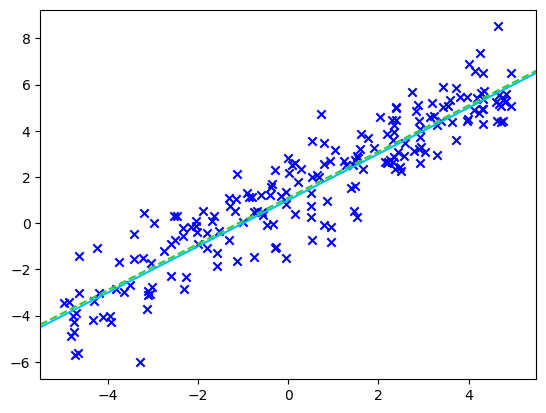

In [58]:
learned_slope = learned_weights[0, 0]
learned_y_intercept = learned_weights[1, 0]

y_min = learned_slope * this_x_min + learned_y_intercept
y_max = learned_slope * this_x_max + learned_y_intercept

this_plot = plot_records(data, this_slope, this_intercept, this_x_min, this_x_max)

this_plot.axline((this_x_min, y_min), (this_x_max, y_max), c='limegreen', linestyle='dashed')
this_plot.show()

Not Bad. Let's try more points and change up the color of the learned line. It blends in.

epoch 10 rmse: 1.0503462876542589, improvement: 0.008146619473303529
weights: [[0.99065439 0.78240664]]

epoch 20 rmse: 1.0191859874209415, improvement: 0.0010303629162249361
weights: [[0.98758533 0.94127686]]

epoch 30 rmse: 1.0153090442032466, improvement: 0.00012656395883503535
weights: [[0.98651197 0.99683895]]

epoch 40 rmse: 1.0148338274880588, improvement: 1.5488500025861995e-05
weights: [[0.98613659 1.01627083]]

epoch 50 rmse: 1.014775687082469, improvement: 1.8945644675305573e-06
weights: [[0.9860053  1.02306679]]

epoch 60 rmse: 1.0147685755326534, improvement: 2.3173147378763304e-07
weights: [[0.98595939 1.02544355]]

epoch 70 rmse: 1.0147677056950046, improvement: 2.834377399452137e-08
weights: [[0.98594333 1.02627479]]

epoch 80 rmse: 1.0147675993025946, improvement: 3.4668095061363147e-09
weights: [[0.98593772 1.0265655 ]]

epoch 90 rmse: 1.0147675862894305, improvement: 4.2403547340086334e-10
weights: [[0.98593575 1.02666717]]

epoch 100 rmse: 1.0147675846977526, improv

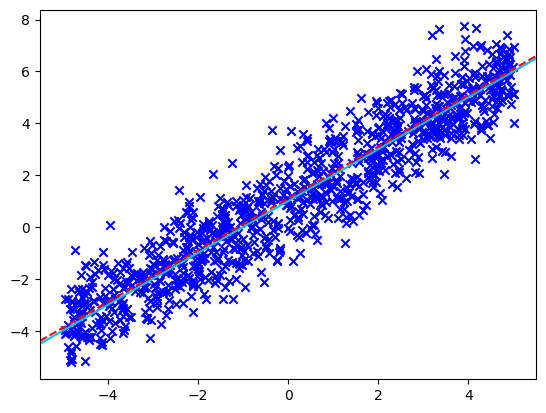

In [59]:
this_num_data_points=1000

data = generate_data_around_straight_line(this_slope, this_intercept, this_num_data_points, this_x_min, this_x_max)

learned_weights = linear_regression(data, num_epochs=200)

this_plot = plot_records(data, this_slope, this_intercept, this_x_min, this_x_max)

y_min = learned_slope * this_x_min + learned_y_intercept
y_max = learned_slope * this_x_max + learned_y_intercept

this_plot.axline((this_x_min, y_min), (this_x_max, y_max), c='red', linestyle='dashed')
this_plot.show()


Not bad! Now, Live Long and Prosper!